![Flight Price Prediction](https://www.amexglobalbusinesstravel.com/content/uploads/2017/11/Night-Landing-iStock-539327295.jpg)

## Step 1: Importing the libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/flight-price-prediction/Data_Train.xlsx
/kaggle/input/flight-price-prediction/Sample_submission.xlsx
/kaggle/input/flight-price-prediction/Test_set.xlsx


## Step 2: Data
### 2.1 Importing the dataset

In [2]:
df = pd.read_excel('../input/flight-price-prediction/Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
#### Checking the shape of the dataframe
df.shape

(10683, 11)

### 2.2 Data Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
## statistical analysis
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


### Step 2.3 Features

1. `Airline`: The name of the airline company.

2. `Date_of_Journey`: The date of the journey they have flew

3. `Source`: Source City

4. `Destination` : Destination of the flight

5. `Route`: Route of the flight including the stopovers

6. `Dep_Time` : Departure Time of the flight from the source

7. `Arrival_Time`: Arrival Time of the flight at the Destination

8. `Duration`: Duration of the flight

9. `Total_Stops` : Total Stops in between (layovers)

10. `Price` : Price of the ticket


### 2.4 Null values

In [6]:
### Checking out the null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

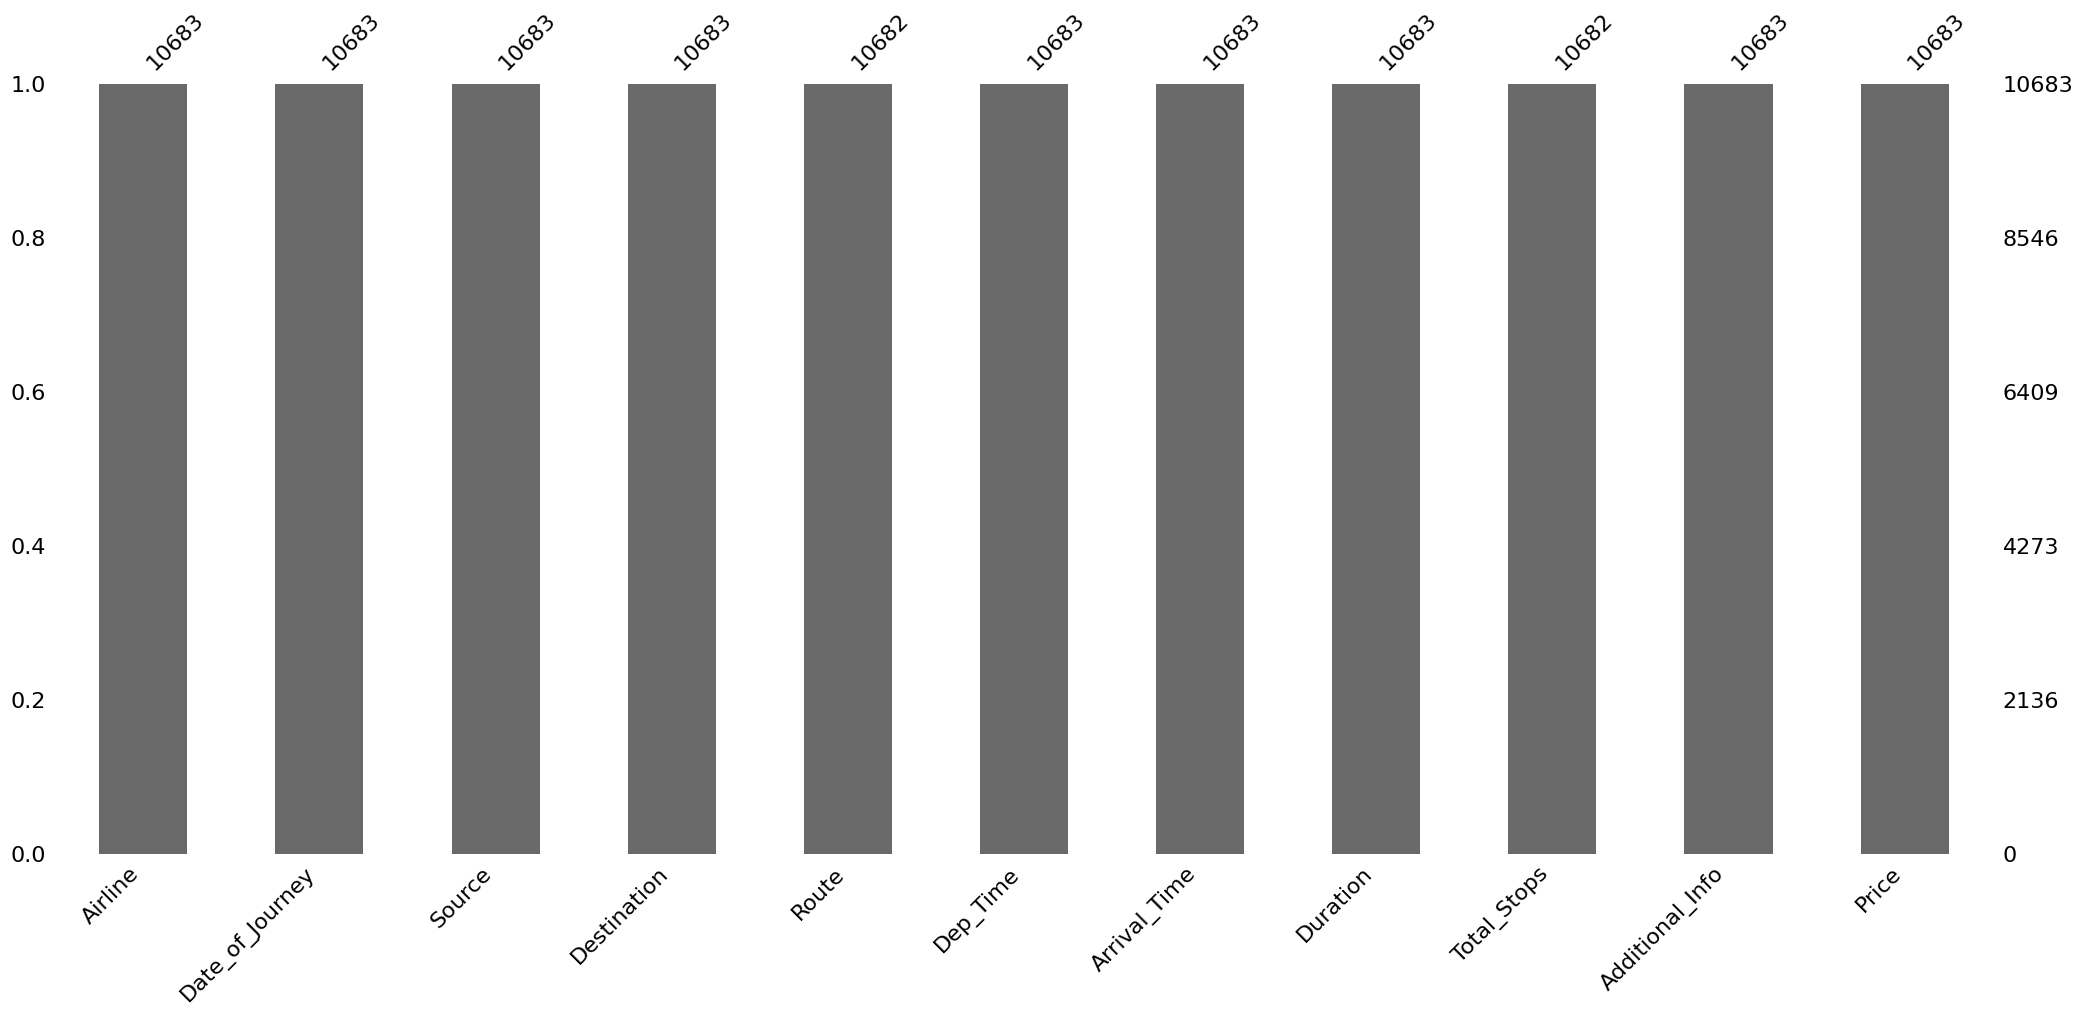

In [7]:
## we can also check the missing values visually
import missingno as msno
msno.bar(df)
plt.show()

- Since only 2 of the values are missing let's drop it

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
## checking the total missing values after dropping
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [9]:
##checking final shape
df.shape

(10682, 11)

## Step 3:Feature Engineering

In [10]:
### Converting the Date_of_Journey to datetime
import datetime as dt
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y')

## Let's Convert the Dep_Time to suitable format and include it in the bins
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'],format ='%H:%M')
df['Dep_Time_hour'] = df['Dep_Time'].dt.hour
df['Dep_Time_mins'] = df['Dep_Time'].dt.minute

## Converting the Arrival_Time to suitable format
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])
df['Arrival_Time_hour'] = df['Arrival_Time'].dt.hour
df['Arrival_Time_mins'] = df['Arrival_Time'].dt.minute

## Converting Duration of the flight to a numerical value
def change_duration_to_minutes(duration):
    if 'h' in duration and 'm' in duration:
        hours,minutes = map(int,duration.replace('h','').replace('m','').split())
        return hours*60+minutes
    elif 'h' in duration:
        hours = int(duration.replace('h',''))
        return hours*60
    else:
        minutes = int(duration.replace('m',''))
        return minutes

df['Duration'] = df['Duration'].apply(change_duration_to_minutes)

### Making New Delhi to Delhi since both are same
df['Destination'].value_counts()
df['Destination'].replace({'New Delhi':'Delhi'},inplace=True)

### Step 4:EDA

### 4.1 Airlines vs Price

<Figure size 640x480 with 0 Axes>

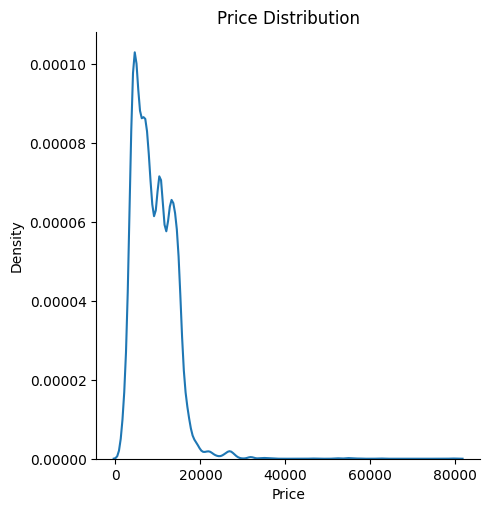

In [11]:
data = df.copy()
plt.figure()
sns.displot(data['Price'],kind='kde')
plt.title('Price Distribution')
plt.show()

- Clearly the values >30000 are outliers here.

In [12]:
## grouping the dataframe by Airlines and then checking the statistical analysis
airline_price = data.groupby('Airline')['Price'].describe(percentiles = [0.25,.5,.75,0.95,.99])

In [13]:
airline_price

,count,mean,std,min,25%,50%,75%,95%,99%,max
Airline,,,,,,,,,,
Air Asia,319.0,5590.260188,2027.362290,3383.0,4282.0,5162.0,6451.00,10722.90,11410.00,13774.0
Air India,1751.0,9612.427756,3901.734561,2050.0,6891.0,9443.0,12219.00,15170.00,22096.00,31945.0
GoAir,194.0,5861.056701,2703.585767,3398.0,3898.0,5135.0,6811.25,10188.00,18623.59,22794.0
IndiGo,2053.0,5673.682903,2264.142168,2227.0,4226.0,5000.0,6494.00,10067.00,14871.00,22153.0
Jet Airways,3849.0,11643.923357,4258.940578,1840.0,9134.0,11467.0,14151.00,17234.00,26890.00,54826.0
Jet Airways Business,6.0,58358.666667,11667.596748,46490.0,52243.0,54747.0,61122.50,75240.75,78657.75,79512.0
Multiple carriers,1196.0,10902.678094,3721.234997,5797.0,7723.0,10197.0,13587.00,16863.00,21500.30,36983.0
Multiple carriers Premium economy,13.0,11418.846154,1717.153936,9845.0,10161.0,11269.0,11269.00,14629.00,14629.00,14629.0
SpiceJet,818.0,4338.284841,1849.922514,1759.0,3574.5,3873.0,4760.00,7988.55,11290.52,23267.0


- Inference:
Outliers are been present in Jet Airways.

In [14]:
jet_airlines =data[data['Airline'] =='Jet Airways']
jet_airlines[jet_airlines['Price']>37000]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,Arrival_Time_mins
1478,Jet Airways,2019-03-18,Banglore,Delhi,BLR → BOM → DEL,1900-01-01 18:40:00,2024-03-16 00:45:00,365,1 stop,No info,54826,18,40,0,45
2618,Jet Airways,2019-03-18,Banglore,Delhi,BLR → BOM → DEL,1900-01-01 22:50:00,2024-03-16 05:05:00,375,1 stop,No info,54826,22,50,5,5
5439,Jet Airways,2019-03-01,Banglore,Delhi,BLR → BOM → DEL,1900-01-01 16:55:00,2024-03-03 23:00:00,365,1 stop,No info,54826,16,55,23,0


### Inference
These are the columns where the price of the flight goes beyond outliers.

#### 4.1.2 Airlines Count in the dataset

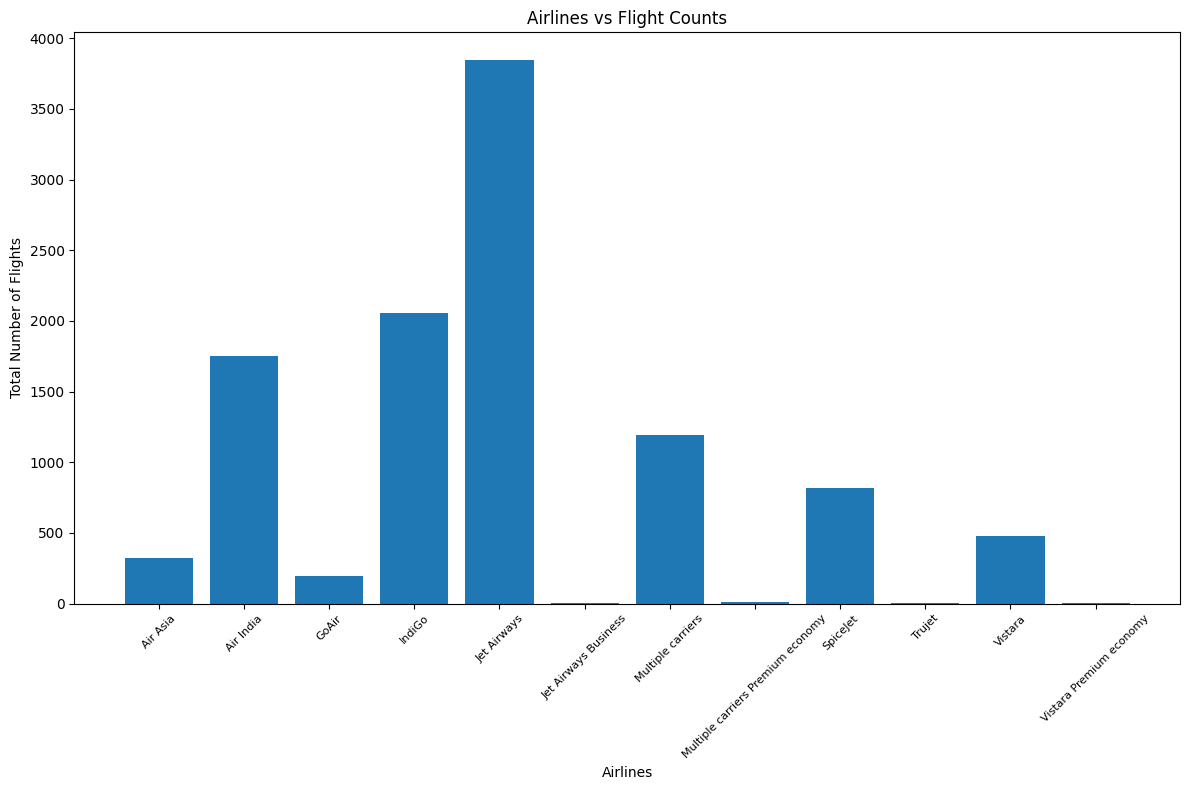

In [15]:
## Plotting a graph between airlines and their count
plt.figure(figsize=(12,8))
plt.bar(airline_price.index,airline_price['count'])
plt.xlabel("Airlines")
plt.xticks(fontsize=8,rotation=45)
plt.ylabel("Total Number of Flights")
plt.title("Airlines vs Flight Counts")
plt.tight_layout()
plt.show()

- Here Clearly Jet Airways have the most frequent number of flights in comparison to others.
- Jet Airways Business, Trujet,Multiple carriers Premium economy,Vistara Premium economy have very negligible amount of flights between the periods between 01/03/2019 and 9/06/2019.

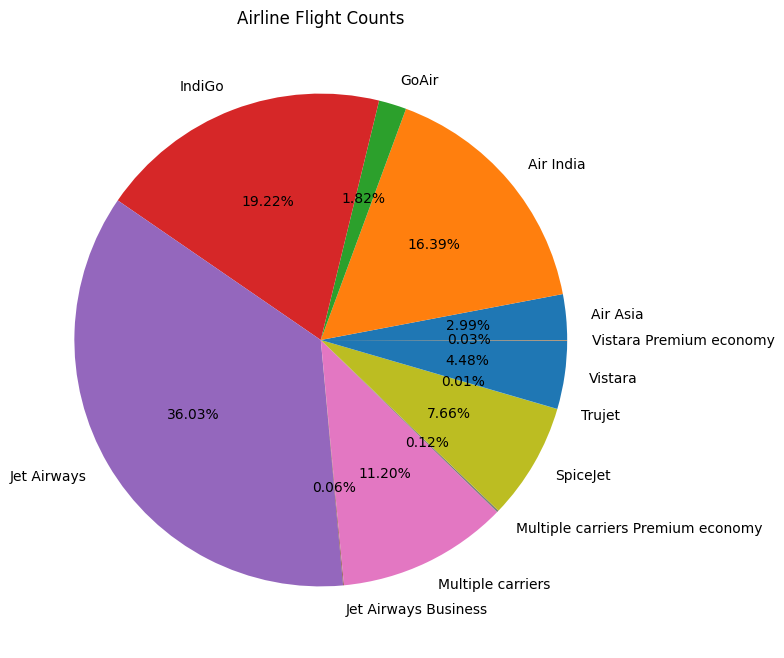

In [16]:
#Let's try to view this in a pie chart
plt.figure(figsize=(8,8))
plt.pie(airline_price['count'],labels=airline_price.index,autopct='%.2f%%')
plt.title('Airline Flight Counts')
plt.show()

- Jet Airways, Indigo and Air India hold a major chunk of the flights.

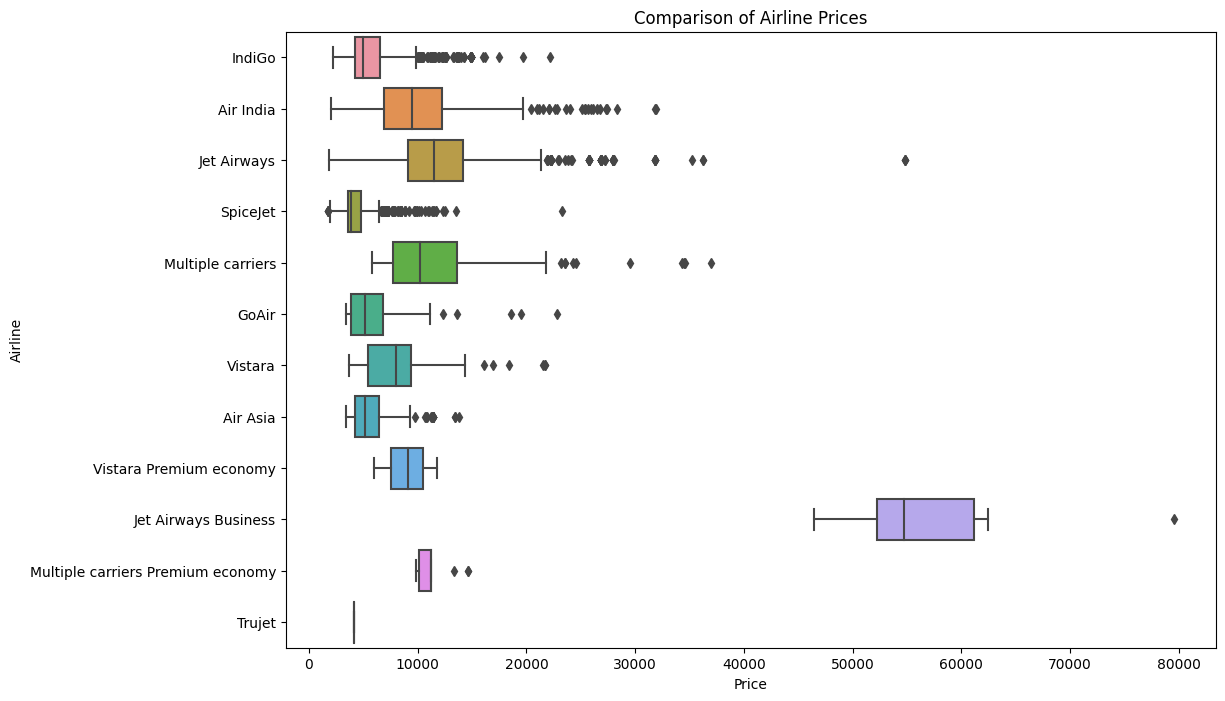

In [17]:
## Airlines vs their prices
plt.figure(figsize=(12,8))
sns.boxplot(data = data,x='Price',y='Airline')
plt.title('Comparison of Airline Prices')
plt.show()

- Inferences
1. Indigo, Spicejet, GoAir,Air Asia, Truejet have lower prices.
2. Jet Airways,Multiple carriers,Vistara Premuium economy have comparatively prices at the higher end.
3. Jet Airways Business have abnormally very high prices among them all.

### 4.2 Price breakdown by total stops

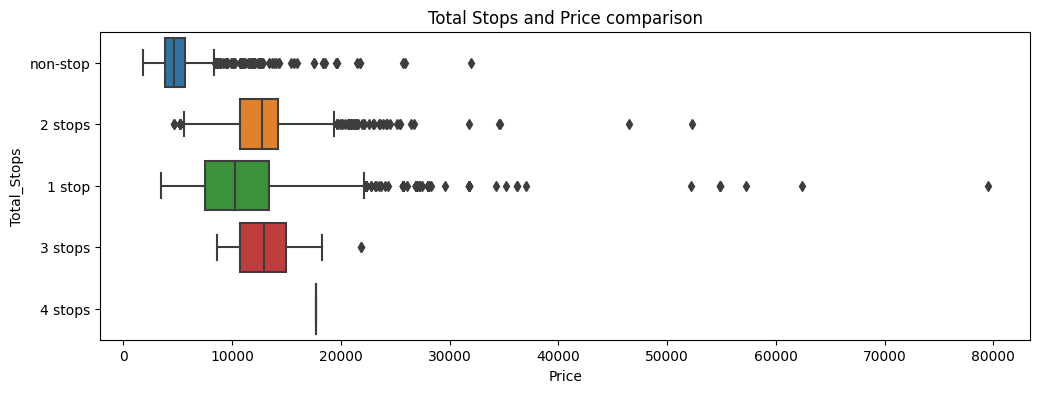

In [18]:
plt.figure(figsize=(12,4))
sns.boxplot(data=data,x='Price',y=data['Total_Stops'])
plt.title("Total Stops and Price comparison")
plt.show()

- Inferences 
1. Here we can clearly see that fligths with 0 stop have comparitively very less price.
2. As we increase the number of stops the price also increases

### 4.3 Duration vs Price

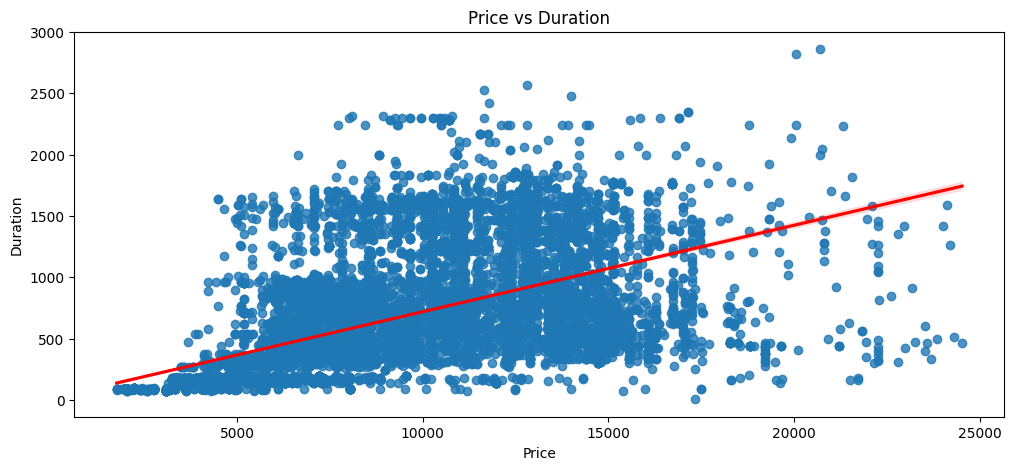

In [19]:
## Build a scatter plot between Duration and Price
plt.figure(figsize=(12,5))
sns.regplot(data=data[data['Price']<25000],x = 'Price',y='Duration',line_kws={'color':'red'})
plt.title("Price vs Duration")
plt.show()

- Inference: Clearly there is a positive relationship between the Price and the Duration.

### 4.4 Price vs Dep_Time

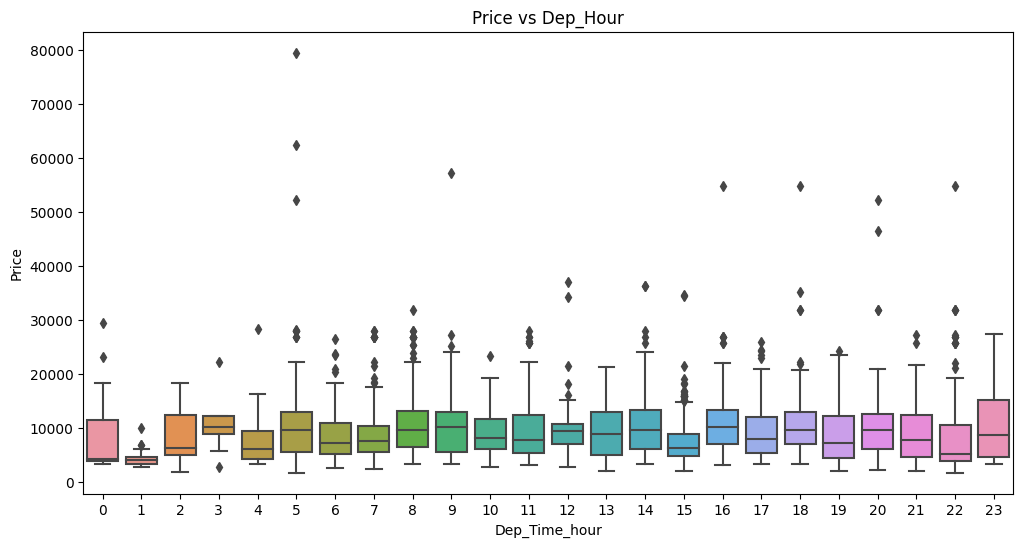

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data,x = 'Dep_Time_hour',y='Price')
plt.title('Price vs Dep_Hour')
plt.show()

- Inferences: Majority of the flights are departing from the airport during the second half of the day.
- When flight is departing at 1am the prices are significantly low.

### 4.5 Price vs Arrival_Hour 

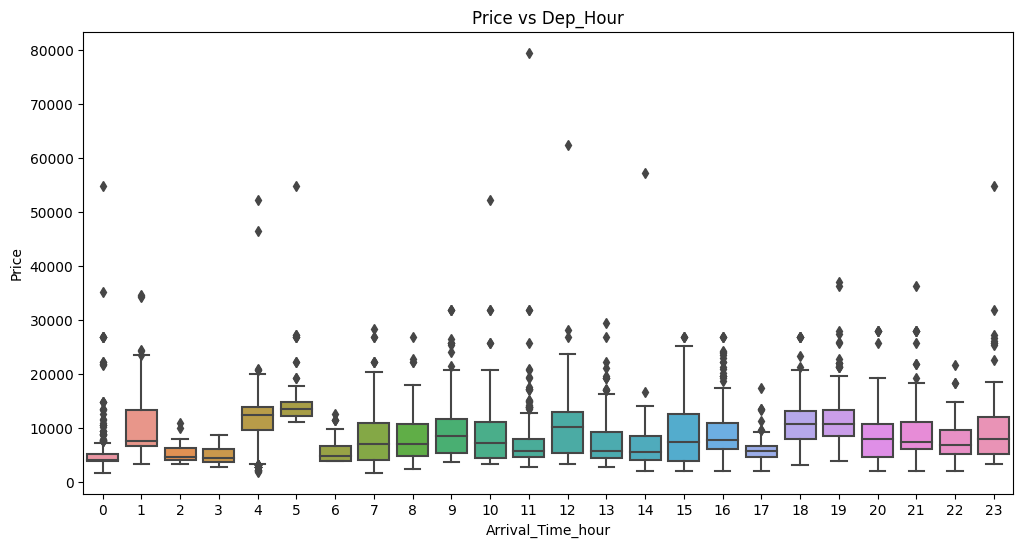

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data,x = 'Arrival_Time_hour',y='Price')
plt.title('Price vs Dep_Hour')
plt.show()

### 4.6 Price vs Additional infoInference
1. Frequency of the arrival times are more during the second half of the day.
2. Prices are comparatively low during early morning hours.

### 4.6 Price vs Additional info

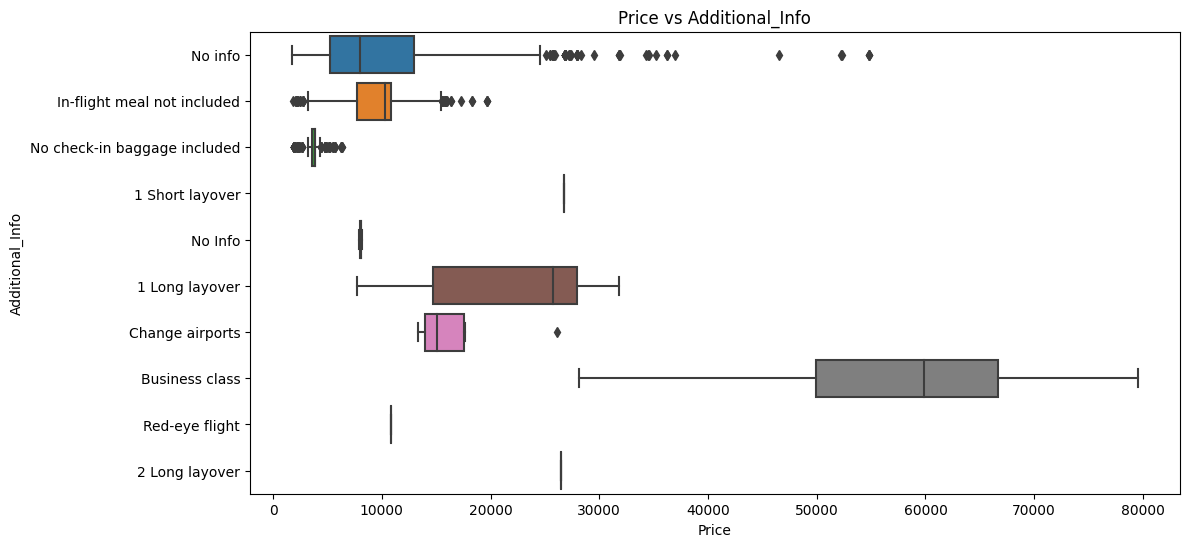

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data,x = 'Price',y=data['Additional_Info'])
plt.title('Price vs Additional_Info')
plt.show()

- Inferences
1. Business class Prices are very huge in comparison to others.
2. Prices are comparitively very low when no check -in baggage is included.
3. When people are changing the airports there is comparitvely more price.

### 4.7 Comparing Date and Price

In [23]:
df_dates = data.groupby('Date_of_Journey')['Price'].describe()
df_dates

,count,mean,std,min,25%,50%,75%,max
Date_of_Journey,,,,,,,,
2019-03-01,199.0,19517.849246,10668.819328,4622.0,11812.00,18387.0,26890.00,79512.0
2019-03-03,315.0,12033.615873,5161.810602,4050.0,7648.00,11762.0,15141.00,46490.0
2019-03-06,403.0,13975.727047,4729.198630,3175.0,11915.00,15077.0,16736.00,52285.0
2019-03-09,302.0,10391.784768,4689.342209,3603.0,6781.25,9575.0,14053.00,34608.0
2019-03-12,142.0,11607.154930,3556.067541,4049.0,11087.00,12014.0,13817.00,23843.0
2019-03-15,162.0,7137.796296,3666.487002,2050.0,5399.25,6657.5,8855.00,27210.0
2019-03-18,156.0,8926.858974,6780.571478,1965.0,4382.25,10909.0,12284.00,54826.0
2019-03-21,423.0,8011.418440,2922.818886,1759.0,6041.00,7738.0,9707.50,14629.0
2019-03-24,323.0,8755.755418,4076.631311,2050.0,5340.00,8033.0,12173.00,31945.0


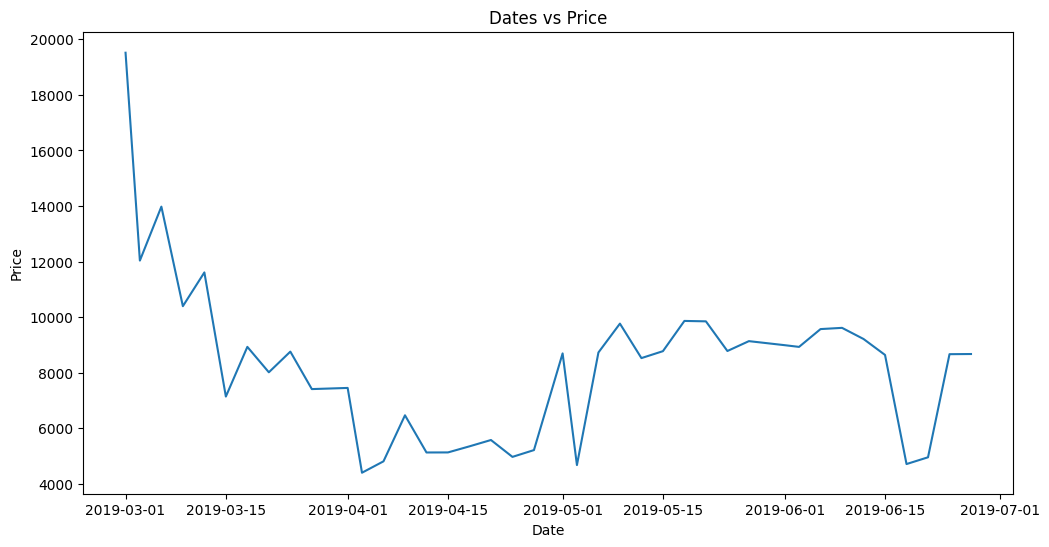

In [24]:
##Plotting the graph
plt.figure(figsize=(12,6))
plt.plot(df_dates['mean'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dates vs Price')
plt.show()

- Inference
1. We can see at the start of March the Prices are very high however it decreases very rapidly.
2. Prices almost become constant around the month of May.
3. There isn't any kind of trend, seasonality we can get over here.

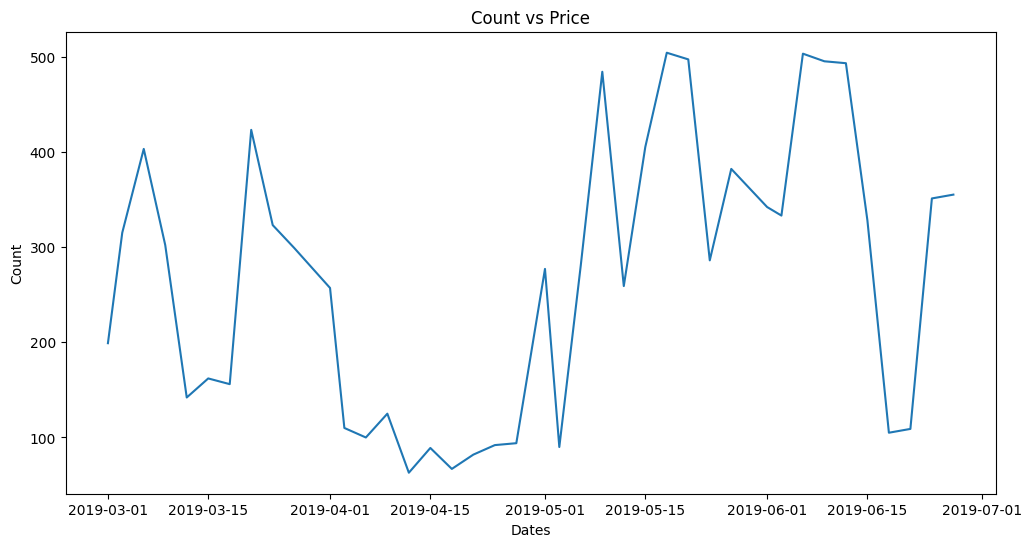

In [25]:
## Plotting Flight Count among these months
plt.figure(figsize=(12,6))
plt.plot(df_dates['count'])
plt.xlabel('Dates')
plt.ylabel('Count')
plt.title('Count vs Price')
plt.show()

- Inference
1. At the start of the month of May significant amount of flights have been increased and it remains constant throughout may to June Mid. 
2. During June sencond week a steep reduction has been seen however then it again rises towards the end of June.

In [26]:
#Let's also compare the Price difference among different airlines along these months
airline_avg_price = data.groupby(['Airline','Date_of_Journey']).mean('Price')[['Price']].reset_index()

In [27]:
## jet airways
jet_airways = airline_avg_price[airline_avg_price['Airline'] =='Jet Airways']
## Indigo
indigo = airline_avg_price[airline_avg_price['Airline'] =='Indigo']
## Air India
air_india = airline_avg_price[airline_avg_price['Airline']=='Air India']
## Multiple carriers
multi_carriers = airline_avg_price[airline_avg_price['Airline']=='Multiple carriers']
## Spicejet
spicejet = airline_avg_price[airline_avg_price['Airline']=='spicejet']

## merging all the dataframes
ar = pd.concat([jet_airways,indigo,air_india,multi_carriers,spicejet])

Text(0.5, 1.0, 'Avg Airline Price vs Months')

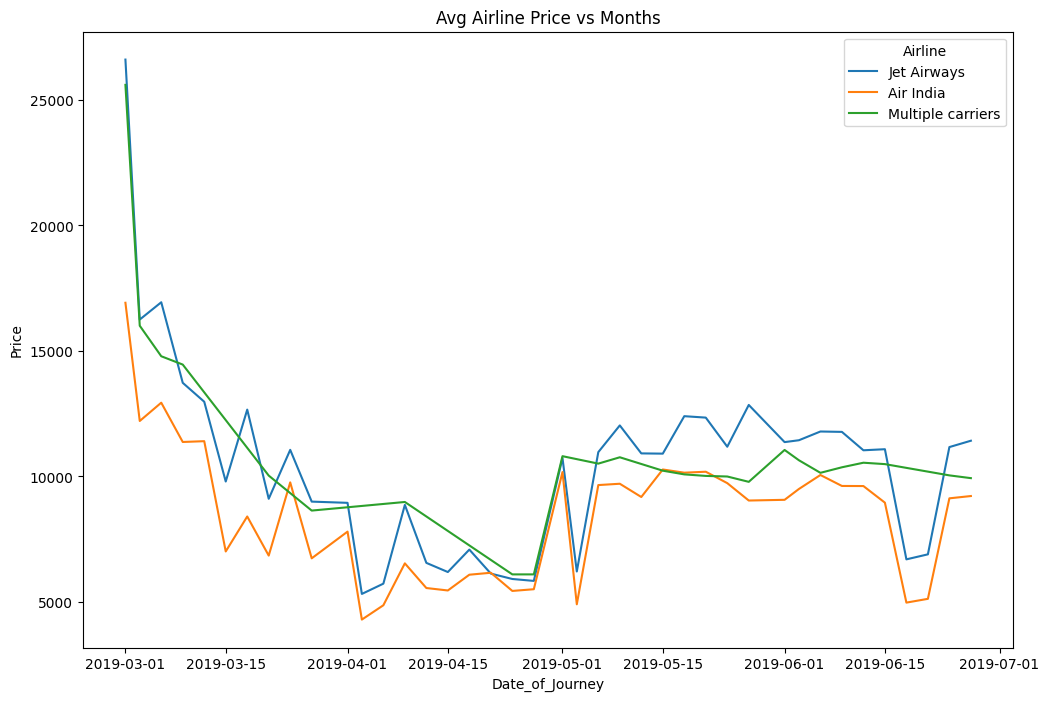

In [28]:
##Plotting the graph for different airlines separately
plt.figure(figsize=(12,8))
sns.lineplot(data = ar ,x='Date_of_Journey',y='Price',hue='Airline')
plt.title('Avg Airline Price vs Months')

- Inference
1. For all the airlines the flight prices significantly reducted at the start of the Month of March.
2. Also for the month of May many of the airlined have had a increase in the Prices and then almost stayed there at a constant rate, this might be due to the fact that there might be a factor of starting of the vacation season.
3. Similar patterns are also observed towards the third week of June where almost for all the airlined there is a sudden decrease in the number of flights.We can take the notion of summer holidays to be impacting these situations maybe.

In [29]:
## Plotting the monthly count by each airlines
monthly_count = data.groupby(['Airline','Date_of_Journey']).count()[['Source']].reset_index()
monthly_count

,Airline,Date_of_Journey,Source
0,Air Asia,2019-03-01,4
1,Air Asia,2019-03-03,7
2,Air Asia,2019-03-06,5
3,Air Asia,2019-03-09,10
4,Air Asia,2019-03-12,2
...,...,...,...
307,Vistara,2019-06-24,8
308,Vistara,2019-06-27,10
309,Vistara Premium economy,2019-03-01,1
310,Vistara Premium economy,2019-03-03,1


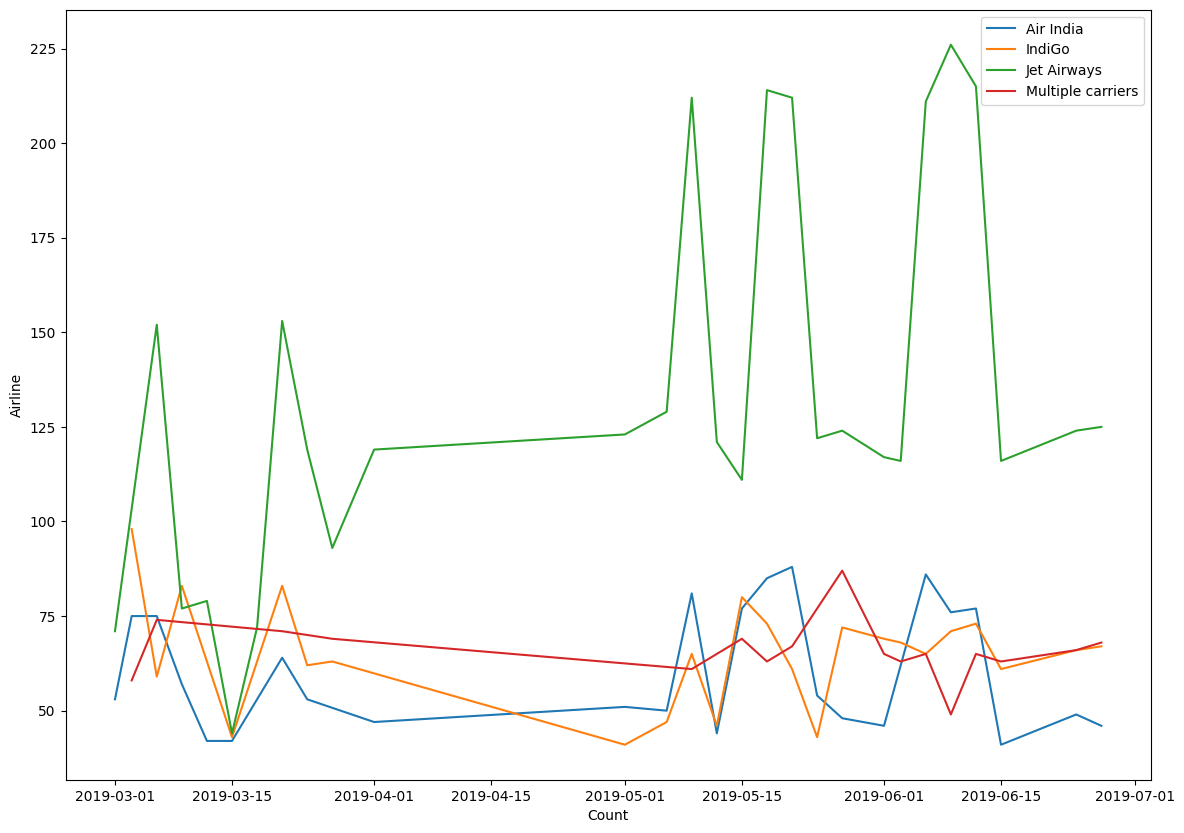

In [30]:
## Plot Airlines vs Count along the months
plt.figure(figsize=(14,10))
sns.lineplot(data=monthly_count[monthly_count['Source']>40],x = 'Date_of_Journey',y='Source',hue='Airline')
plt.xlabel('Count')
plt.ylabel('Airline')
plt.legend(loc='best')
plt.show()

- Inference
1. We can see that Jet Airways have the count of flights the highest all along these months. This is the same inference we have got from the pie chart.
2. Air India, Indigo are the other top candidates.
3. Note: Multiple carriers denote that the flights have been changed during layovers.

### 4.8 Multiple Carriers 

In [31]:
## Analysing Multiple Carriers
multi_carr = data[data['Airline']=='Multiple carriers']
multi_carr.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,Arrival_Time_mins
9,Multiple carriers,2019-05-27,Delhi,Cochin,DEL → BOM → COK,1900-01-01 11:25:00,2024-03-03 19:15:00,470,1 stop,No info,8625,11,25,19,15
40,Multiple carriers,2019-05-21,Delhi,Cochin,DEL → HYD → COK,1900-01-01 07:05:00,2024-03-03 18:10:00,665,1 stop,No info,9646,7,5,18,10


### 4.9 Analyzing the most common Routes

In [32]:
#Checking out the top common routes
routes = data.groupby('Route').count()

In [33]:
top_routes= routes[routes['Airline']>400].sort_values(by='Airline',ascending=False)

In [34]:
#getting the top_routes and getting the list
top_routes_index = top_routes.index
df_routes = df.copy()
df_routes.set_index('Route',inplace=True)
#Getting the mean prices of the top_routes
mean_price=[]
for i in top_routes_index:
    mean_price.append(df_routes.loc[i]['Price'].mean())

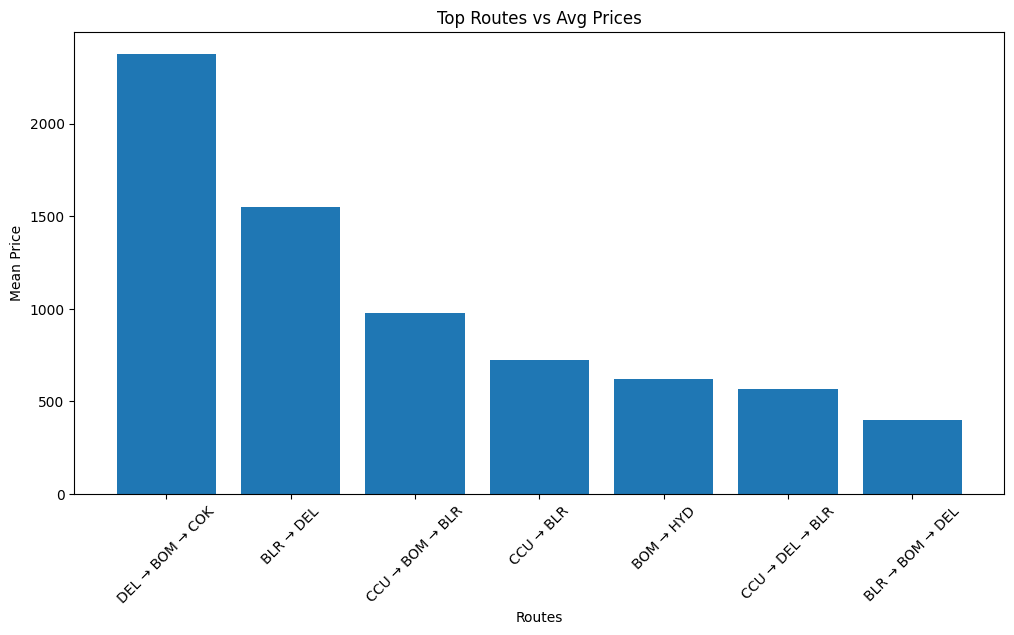

In [35]:
## Plotting the price between the top routes and average prices
plt.figure(figsize=(12,6))
plt.bar(top_routes.index,top_routes['Price'])
plt.xlabel('Routes')
plt.xticks(rotation=45)
plt.ylabel('Mean Price')
plt.title('Top Routes vs Avg Prices')
plt.show()

- Inferences
1. BLR->BOM-> DEL has the lowest mean price among the top Routes.
2. DEL-->BOM->COK has the highest mean price among the top Routes

## Step 5: Feature Engineering

In [36]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,Arrival_Time_mins
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,1900-01-01 22:20:00,2024-03-22 01:10:00,170,non-stop,No info,3897,22,20,1,10
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,1900-01-01 05:50:00,2024-03-03 13:15:00,445,2 stops,No info,7662,5,50,13,15


In [37]:
### get dummies variable
## Airline
airline = pd.get_dummies(df['Airline'],drop_first=True,prefix='Airline')
source = pd.get_dummies(df['Source'],drop_first=True,prefix='Source')
destination = pd.get_dummies(df['Destination'],drop_first=True,prefix='Destination')

## Splitting the Route column to Route 1, Route 2 , Route 3, Route 4


def split(x):
    return x.split()[0::2]

df['Route'] = df['Route'].apply(split)

# Splitting routes into separate columns
df[['Route1', 'Route2', 'Route3', 'Route4','Route5','Route6']] = df['Route'].apply(lambda x: pd.Series(x))


## Dropping the original columns
cols_todrop= ['Airline','Route','Source','Destination']
df.drop(cols_todrop,axis=1,inplace=True)

In [38]:
df.head(2)

,Date_of_Journey,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,Arrival_Time_mins,Route1,Route2,Route3,Route4,Route5,Route6
0,2019-03-24,1900-01-01 22:20:00,2024-03-22 01:10:00,170,non-stop,No info,3897,22,20,1,10,BLR,DEL,NaN,NaN,NaN,NaN
1,2019-05-01,1900-01-01 05:50:00,2024-03-03 13:15:00,445,2 stops,No info,7662,5,50,13,15,CCU,IXR,BBI,BLR,NaN,NaN


In [39]:
df['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [40]:
### Encoding the columns now
### Total_Stops
df.loc[:,'Total_Stops'] = df.loc[:,'Total_Stops'].replace({
    '1 stop':1,
    'non-stop':0,
    '2 stops':2,
    '3 stops':3,
    '4 stops':4
})
df['Total_Stops'] = df['Total_Stops'].apply(lambda x: int(x))
    
### LabelEncoding
le = LabelEncoder()
df.loc[:,'Route1'] = le.fit_transform(df['Route1'])
df.loc[:,'Route2'] = le.fit_transform(df['Route2'])
df.loc[:,'Route3'] = le.fit_transform(df['Route3'])
df.loc[:,'Route4'] = le.fit_transform(df['Route4'])
df.loc[:,'Route5'] = le.fit_transform(df['Route5'])
df.loc[:,'Route6'] = le.fit_transform(df['Route6'])
df.loc[:,'Additional_Info']  =le.fit_transform(df['Additional_Info'])

In [41]:
df.shape

(10682, 17)

In [42]:
## Combining  the dummies
combined = pd.concat([airline,source,destination],axis=1)
cols = combined.columns

### Mapping the boolean values to 1 and 0
for i in cols:
    combined[i] = combined[i].map({True:1,False:0})

    
## Concatenating to the main column
df= pd.concat([df,combined],axis=1)
df.head()

,Date_of_Journey,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,2019-03-24,1900-01-01 22:20:00,2024-03-22 01:10:00,170,0,8,3897,22,20,1,...,0,0,0,0,0,0,0,1,0,0
1,2019-05-01,1900-01-01 05:50:00,2024-03-03 13:15:00,445,2,8,7662,5,50,13,...,0,0,0,0,1,0,0,0,0,0
2,2019-06-09,1900-01-01 09:25:00,2024-06-10 04:25:00,1140,2,8,13882,9,25,4,...,0,0,0,1,0,0,1,0,0,0
3,2019-05-12,1900-01-01 18:05:00,2024-03-03 23:30:00,325,1,8,6218,18,5,23,...,0,0,0,0,1,0,0,0,0,0
4,2019-03-01,1900-01-01 16:50:00,2024-03-03 21:35:00,285,1,8,13302,16,50,21,...,0,0,0,0,0,0,0,1,0,0


In [43]:
print(df.shape)

(10682, 36)


### 5.2 Checking outliers

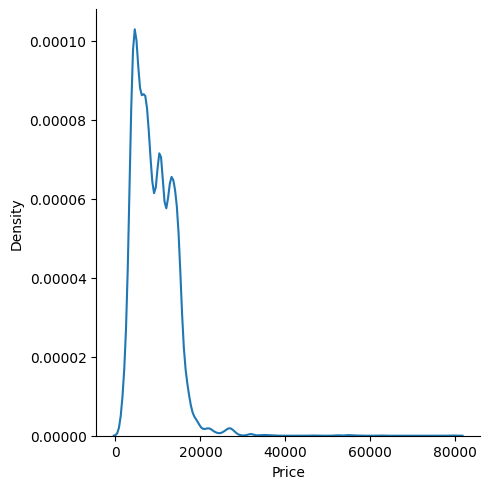

In [44]:
sns.displot(df['Price'],kind='kde')

In [45]:
## Handling outliers
df.loc[df['Price']>40000,'Price'] = np.median(df['Price'])

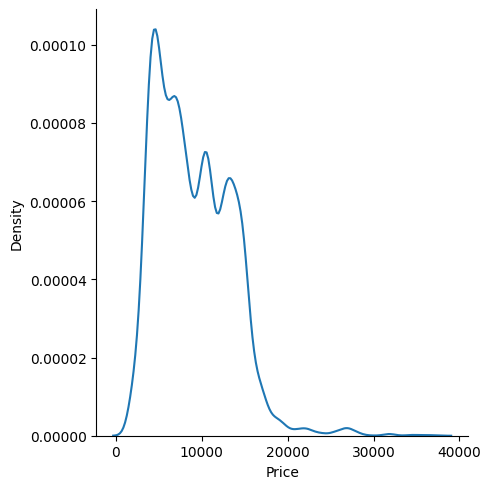

In [46]:
sns.displot(df['Price'],kind='kde')

#### 5.4 Dropping Columns

In [47]:
## Dropping unwanted columns
df.drop(['Date_of_Journey','Dep_Time','Arrival_Time','Route6'],axis=1,inplace=True)
df.head(2)

,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,Arrival_Time_mins,Route1,Route2,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,170,0,8,3897,22,20,1,10,0,10,...,0,0,0,0,0,0,0,1,0,0
1,445,2,8,7662,5,50,13,15,2,20,...,0,0,0,0,1,0,0,0,0,0


### 5.4 Normalizing

In [48]:
scaler =MinMaxScaler()
cols = df.columns
df = pd.DataFrame(scaler.fit_transform(df),columns = cols)
df.head()

,Duration,Total_Stops,Additional_Info,Price,Dep_Time_hour,Dep_Time_mins,Arrival_Time_hour,Arrival_Time_mins,Route1,Route2,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.057793,0.00,0.888889,0.060697,0.956522,0.363636,0.043478,0.181818,0.00,0.256410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.154116,0.50,0.888889,0.167585,0.217391,0.909091,0.565217,0.272727,0.50,0.512821,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.397548,0.50,0.888889,0.344169,0.391304,0.454545,0.173913,0.454545,0.75,0.692308,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.112084,0.25,0.888889,0.126590,0.782609,0.090909,1.000000,0.545455,0.50,0.743590,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.098074,0.25,0.888889,0.327703,0.695652,0.909091,0.913043,0.636364,0.00,0.743590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 5.5 Splitting the dataset

In [49]:
X = df.drop('Price',axis=1)
y = df.Price

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=100)

### 5.6 Checking the Correlation

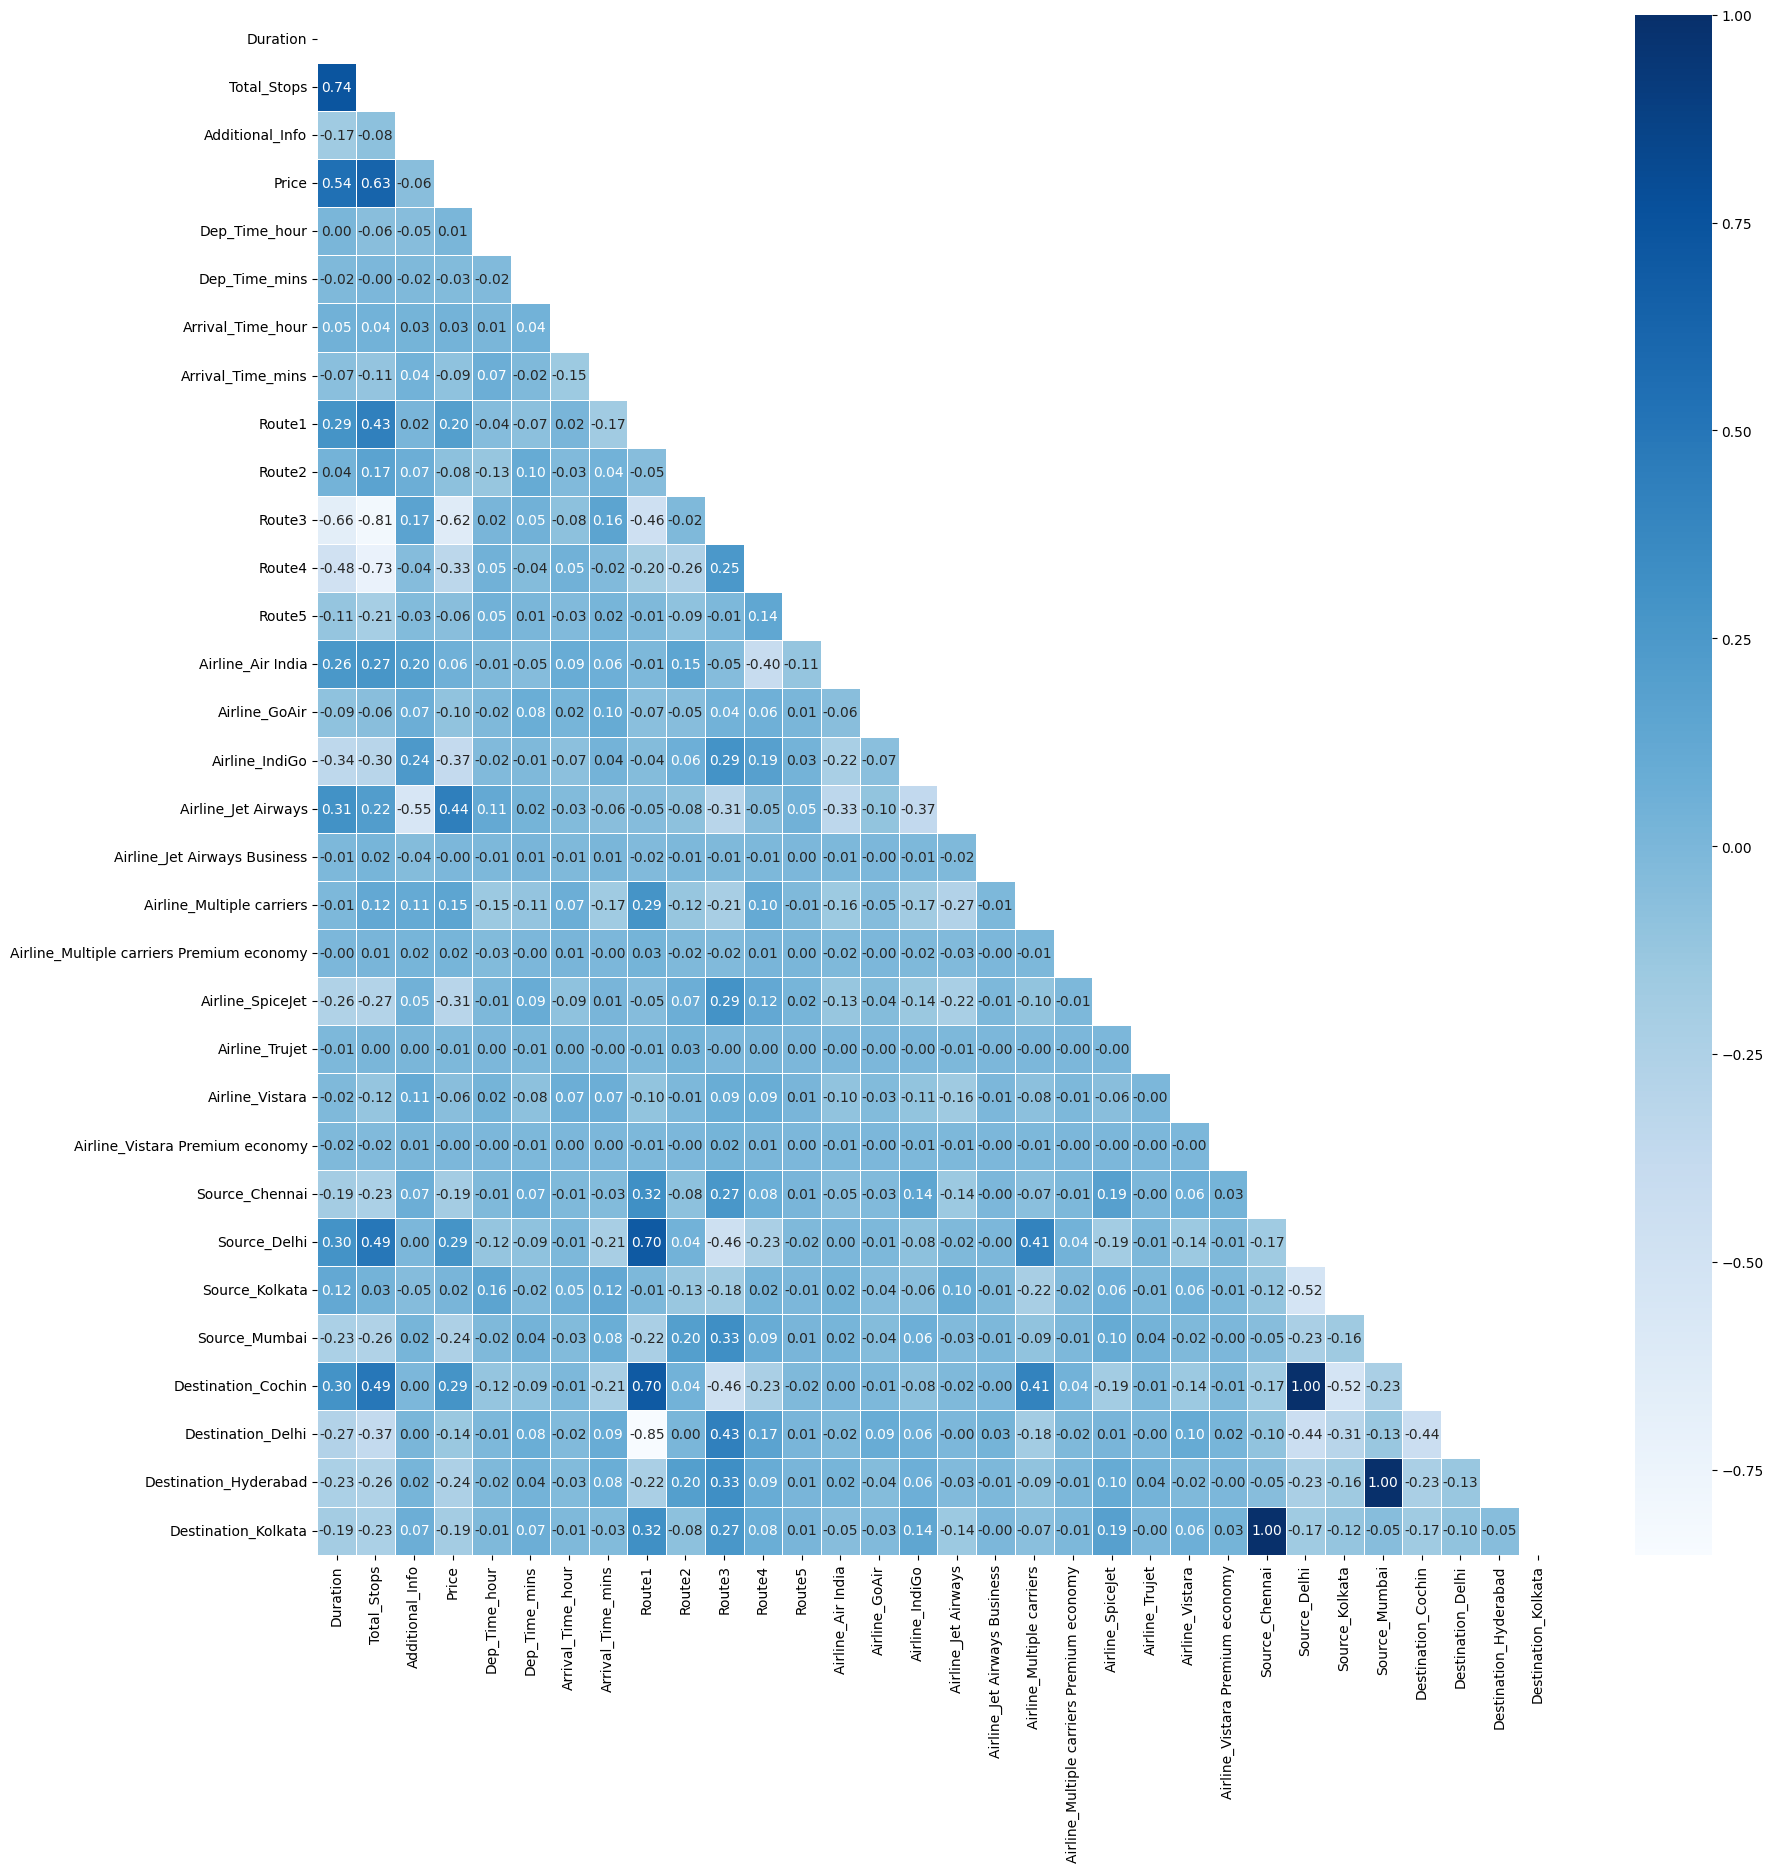

In [50]:
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, linecolor='white', mask=np.triu(corr), cmap='Blues')
plt.show()

- High correlation
1. Total_Stops- Duration
2. Total_Stops- Route3 and Route4
3. Source_Delhi- Route1
4. Destination_Cochin- Route1
5. Destination_Delhi- Route1
6. Destination_Cochin - Source_Delhi
7. Destination_Kolkata- Source_Chennai
8. Destination_Hyderabad- Source_Mumbai

- Clearly many of the independent variables are highly correlated with each other.
- Inf means there is perfect multicollinearity between the variables
- We will deal with the important features later, let's first build some models.

In [51]:
## Dropping one of the columns having perfect multicollinearity
X_train1 = X_train.drop(['Destination_Kolkata','Destination_Cochin','Destination_Hyderabad'],axis=1)

In [52]:
#### Checking the important features now
imp = pd.DataFrame()
imp['Features'] = X_train1.columns
imp['Importance'] = mutual_info_regression(X_train1,y_train)
imp = imp.sort_values(by='Importance',ascending=False)
imp.reset_index(drop=True,inplace=True)

<BarContainer object of 10 artists>

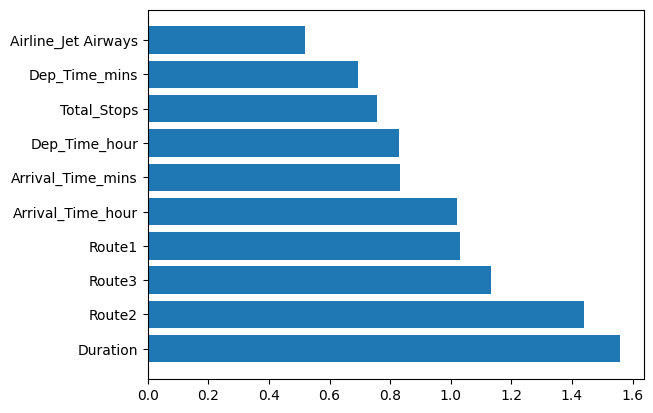

In [53]:
plt.barh(imp['Features'][:10],imp['Importance'][:10])

In [54]:
imp

,Features,Importance
0,Duration,1.559072
1,Route2,1.441090
2,Route3,1.132300
3,Route1,1.029317
4,Arrival_Time_hour,1.019581
5,Arrival_Time_mins,0.831918
6,Dep_Time_hour,0.830447
7,Total_Stops,0.758191
8,Dep_Time_mins,0.693091
9,Airline_Jet Airways,0.520460


In [55]:
## Dropping the columns having least dependency with output variable
X_train2 = X_train1.drop(['Airline_Vistara Premium economy',
    'Airline_Multiple carriers Premium economy',
    'Airline_Jet Airways Business',
    'Airline_Trujet'],axis=1)
## Final columns to be selected in model building
cols = X_train2.columns
cols

Index(['Duration', 'Total_Stops', 'Additional_Info', 'Dep_Time_hour',
       'Dep_Time_mins', 'Arrival_Time_hour', 'Arrival_Time_mins', 'Route1',
       'Route2', 'Route3', 'Route4', 'Route5', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Multiple carriers', 'Airline_SpiceJet', 'Airline_Vistara',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Delhi'],
      dtype='object')

## Step 6: Model Building

### 6.1 PCA 

In [56]:
pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train)

PCA(n_components=31)

In [57]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.28306126, 0.42474011, 0.52999425, 0.6068455 , 0.6669045 ,
       0.71814474, 0.76589704, 0.80649271, 0.84346859, 0.8723303 ,
       0.89771235, 0.9204548 , 0.94006256, 0.95781087, 0.97068454,
       0.97914128, 0.98705815, 0.99199083, 0.99621672, 0.9977515 ,
       0.99900219, 0.99944669, 0.99965123, 0.99984372, 0.99994787,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

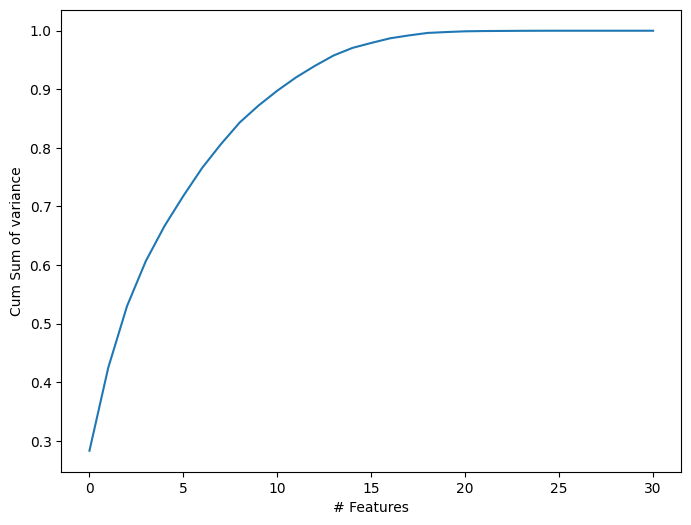

In [58]:
### Plotting the pca graph to check the optimal number of parameters
plt.figure(figsize=(8,6))
plt.plot(range(31),cumsum)
plt.xlabel('# Features')
plt.ylabel('Cum Sum of variance')
plt.show()

- We can select 18 features as the optimal # features

In [59]:
## Initiating PCA again
pca = PCA(n_components=18)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_train_pca.columns = ['PCA_'+str(i) for i in range(X_train_pca.shape[1])]
X_test_pca = pd.DataFrame(pca.transform(X_test))
X_test_pca.columns = ['PCA_'+str(i) for i in range(X_test_pca.shape[1])]

### 6.1 Linear Regression

In [60]:
lr = LinearRegression()
lr.fit(X_train_pca,y_train)
y_train_pred = lr.predict(X_train_pca)
res = y_train-y_train_pred
train_score = r2_score(y_train,y_train_pred)
print('Train_score:',train_score)

Train_score: 0.5924280293981423


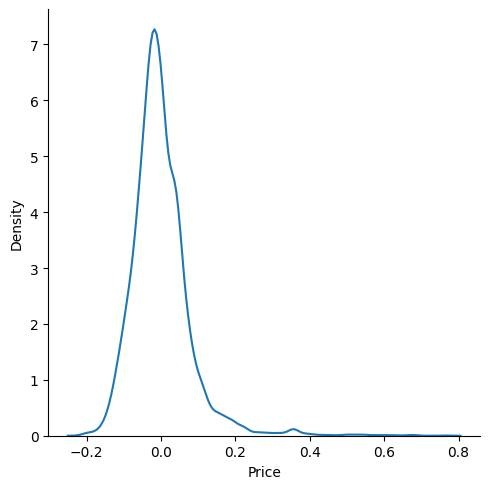

In [61]:
### Residual analysis
sns.displot(res,kind='kde')
plt.show()

- The residuals follow a normal distribution.

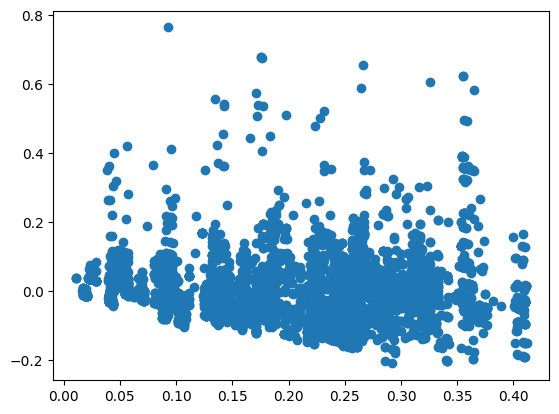

In [62]:
plt.scatter(y_train_pred,res)

- There seems to be some kind of pattern here, however we will build other models further down the road.

### Making predictions on the test set

In [63]:
y_pred = lr.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)

In [64]:
res = pd.DataFrame(columns=['Algorithm','Train score','Test score'])
res.loc[len(res)] = ['LR',train_score,r2]
res

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957


### 6.2 Random Forest

In [65]:
rf = RandomForestRegressor(max_depth=5)
rf.fit(X_train_pca,y_train)

RandomForestRegressor(max_depth=5)

In [66]:
y_train_pred = rf.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print(train_score)
y_pred = lr.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print(r2)

0.7150967337734477
0.6319573221703159


In [67]:
res.loc[len(res)] = ['Random Forest',train_score,r2]
res

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957


### 6.3 Decision Tree

In [68]:
dt = DecisionTreeRegressor(max_depth=9)
dt.fit(X_train_pca,y_train)
y_train_pred = dt.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print(train_score)
y_pred = dt.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print(r2)

0.7977034469036317
0.7296133754860503


In [69]:
res.loc[len(res)] = ['Decision Tree',train_score,r2]
res

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613


### 6.4 Gradient Boost

In [70]:
gb = GradientBoostingRegressor()
gb.fit(X_train_pca,y_train)
y_train_pred = gb.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train Score:',train_score)
y_pred = gb.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)

Train Score: 0.7600689955122337
Test Score: 0.7503765691619572


In [71]:
res.loc[len(res)] = ['Gradient Boost',train_score,r2]
res

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377


### 6.5 XGBoost

In [78]:
xgb = XGBRegressor()
xgb.fit(X_train_pca,y_train)
y_train_pred = xgb.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train Score:',train_score)
y_pred = xgb.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)

Train Score: 0.856553065325891
Test Score: 0.7599176026648404


In [79]:
res.loc[len(res)] = ['XG Boost',train_score,r2]
res

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377
4,XG Boost,0.856553,0.759918


### 6.5 Cat Boost

In [80]:
cat = CatBoostRegressor()
cat.fit(X_train_pca,y_train)
y_train_pred = cat.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train Score:',train_score)
y_pred = cat.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)

Learning rate set to 0.056264
0:	learn: 0.1211725	total: 64ms	remaining: 1m 3s
1:	learn: 0.1177925	total: 69ms	remaining: 34.4s
2:	learn: 0.1143895	total: 75.2ms	remaining: 25s
3:	learn: 0.1109331	total: 81.4ms	remaining: 20.3s
4:	learn: 0.1078563	total: 86.6ms	remaining: 17.2s
5:	learn: 0.1051325	total: 92.5ms	remaining: 15.3s
6:	learn: 0.1024895	total: 97.6ms	remaining: 13.8s
7:	learn: 0.1000984	total: 104ms	remaining: 12.9s
8:	learn: 0.0979136	total: 110ms	remaining: 12.1s
9:	learn: 0.0957120	total: 115ms	remaining: 11.4s
10:	learn: 0.0937407	total: 120ms	remaining: 10.8s
11:	learn: 0.0919163	total: 128ms	remaining: 10.5s
12:	learn: 0.0902452	total: 135ms	remaining: 10.3s
13:	learn: 0.0887817	total: 141ms	remaining: 9.93s
14:	learn: 0.0874618	total: 146ms	remaining: 9.6s
15:	learn: 0.0861325	total: 151ms	remaining: 9.31s
16:	learn: 0.0849190	total: 156ms	remaining: 9.05s
17:	learn: 0.0837883	total: 174ms	remaining: 9.47s
18:	learn: 0.0826740	total: 187ms	remaining: 9.66s
19:	learn: 

In [81]:
res.loc[len(res)] = ['Cat Boost',train_score,r2]
res

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377
4,XG Boost,0.856553,0.759918
5,Cat Boost,0.843389,0.777825


- So far Cat Boost is the best Algorithm we have yet. 

## Step 7. Hyper parameter Tuning

### 7.1 On Decision Tree

In [82]:
## param grid
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'random_state': [42]  # Random seed for reproducibility
}


grid_search = GridSearchCV(estimator=dt,param_grid=param_grid
                            ,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(X_train_pca,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(max_depth=9), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [83]:
dt_best = grid_search.best_estimator_
dt_best.fit(X_train_pca,y_train)
y_train_pred = dt_best.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train_score:',train_score)
y_pred = dt_best.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)
res.loc[len(res)] = ['GridSearch DT',train_score,r2]
res

Train_score: 0.8188274504453517
Test Score: 0.7196665355320127


,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377
4,XG Boost,0.856553,0.759918
5,Cat Boost,0.843389,0.777825
6,GridSearch DT,0.818827,0.719667


### 7.2 On XgBoost

In [84]:
param_grid = {
    'learning_rate': [0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.09,0.1],  # Learning rate
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of a tree
    'n_estimators': [100,150,200],  # Number of trees in the forest
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization term on weights
    'random_state': [42]  # Random seed for reproducibility
}

random_search = RandomizedSearchCV(estimator=xgb,param_distributions=param_grid,
                            verbose=3,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
random_search.fit(X_train_pca,y_train)

xgb_best = random_search.best_estimator_
y_train_pred = xgb_best.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train_score:',train_score)
y_pred = xgb_best.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)
res.loc[len(res)] = ['RandomSearch XGBoost',train_score,r2]
res

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train_score: 0.7951240476729142
Test Score: 0.7727716224779333


,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377
4,XG Boost,0.856553,0.759918
5,Cat Boost,0.843389,0.777825
6,GridSearch DT,0.818827,0.719667
7,RandomSearch XGBoost,0.795124,0.772772


### 7.3 On Gradient Boost

In [85]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of boosting stages
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of the individual estimators
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for fitting the individual base learners # Random seed for reproducibility
}

random_search = RandomizedSearchCV(estimator=gb,param_distributions=param_grid,
                            verbose=3,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
random_search.fit(X_train_pca,y_train)

gb_best = random_search.best_estimator_
y_train_pred = gb_best.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train_score:',train_score)
y_pred = gb_best.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)
res.loc[len(res)] = ['RandomSearch GradientBoost',train_score,r2]
res

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train_score: 0.8101011310401895
Test Score: 0.7655317175916154


,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377
4,XG Boost,0.856553,0.759918
5,Cat Boost,0.843389,0.777825
6,GridSearch DT,0.818827,0.719667
7,RandomSearch XGBoost,0.795124,0.772772
8,RandomSearch GradientBoost,0.810101,0.765532


### 7.3 On CatBoost

In [86]:
param_grid = { 
    'depth': [4, 6, 8, 10],  # Depth of trees
}


random_search = RandomizedSearchCV(estimator=cat,param_distributions=param_grid
                            ,n_jobs=-1,cv=5,scoring='neg_mean_squared_error',verbose=False)
random_search.fit(X_train_pca,y_train)

cat_best = random_search.best_estimator_
y_train_pred = cat_best.predict(X_train_pca)
train_score = r2_score(y_train,y_train_pred)
print('Train_score:',train_score)
y_pred = cat_best.predict(X_test_pca)
r2 = r2_score(y_test,y_pred)
print('Test Score:',r2)
res.loc[len(res)] = ['RandomSearch CatBoost',train_score,r2]
res

[CV 3/5] END gamma=0.3, learning_rate=0.07, max_depth=4, n_estimators=200, random_state=42, reg_alpha=1.0, reg_lambda=0.1;, score=-0.005 total time=   0.4s
[CV 2/5] END gamma=0, learning_rate=0.09, max_depth=5, n_estimators=100, random_state=42, reg_alpha=1.0, reg_lambda=1.0;, score=-0.004 total time=   0.8s
[CV 5/5] END gamma=0, learning_rate=0.09, max_depth=5, n_estimators=100, random_state=42, reg_alpha=1.0, reg_lambda=1.0;, score=-0.003 total time=   0.9s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=42, reg_alpha=1.0, reg_lambda=0.5;, score=-0.007 total time=   0.9s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=42, reg_alpha=1.0, reg_lambda=0.5;, score=-0.006 total time=   0.9s
[CV 2/5] END gamma=0.1, learning_rate=0.07, max_depth=6, n_estimators=150, random_state=42, reg_alpha=1.0, reg_lambda=0;, score=-0.005 total time=   0.5s
[CV 1/5] END gamma=0.4, learning_rate=0.03, max_depth=6, n_estimators=

,Algorithm,Train score,Test score
0,LR,0.592428,0.631957
1,Random Forest,0.715097,0.631957
2,Decision Tree,0.797703,0.729613
3,Gradient Boost,0.760069,0.750377
4,XG Boost,0.856553,0.759918
5,Cat Boost,0.843389,0.777825
6,GridSearch DT,0.818827,0.719667
7,RandomSearch XGBoost,0.795124,0.772772
8,RandomSearch GradientBoost,0.810101,0.765532
9,RandomSearch CatBoost,0.819947,0.776673
